In [415]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.feature_detection.class_frame_pair import FramePair
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from DLC_for_WBFM.utils.postures.centerline_pca import WormFullVideoPosture, WormSinglePosture
from DLC_for_WBFM.utils.external.centerline_utils import transform_neuron_point_cloud
import time
from torch.utils.data import DataLoader
import math
from tqdm.auto import tqdm
import wandb
import torch.nn.functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
fname = "/home/charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

Output files: /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/global2tracklet_manual.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/manually_split_tracklets.h5, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_names.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [4]:

fname1 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_X_coords.csv"
fname2 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_Y_coords.csv"
fname3 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_K.csv"

worm_posture = WormFullVideoPosture(fname1, fname2, fname3)

# Scratch: Use a transformer to encode

In [5]:
t = 0
def build_worm_at_time(t):
    pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
    centerline0 = worm_posture.get_centerline_for_time(t)
    return WormSinglePosture(pts0, centerline0)

In [6]:
n_neighbors = 20
i_anchor = 50

n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)

In [7]:
n0.shape

(20, 3)

In [8]:
import torch
from self_attention_cv import AxialAttentionBlock

In [9]:

model = RectAxialAttentionBlock(in_channels=1, dim_h=20, dim_w=3, heads=8)
# x = torch.rand(1, 256, 20, 20)  # [batch, tokens, dim, dim]
t_n0 = torch.unsqueeze(torch.from_numpy(np.array([n0])), dim=0).float()
y = model(t_n0)


NameError: name 'RectAxialAttentionBlock' is not defined

In [ ]:

model = RectAxialEncoder(in_channels=1, dim_h=20, dim_w=3, heads=8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

y = model(t_n0.to(device))
y

# Build a student and teacher model

In [ ]:

# Get test data
# i_anchor = 0
# test_data = []
# for i_anchor in range(len(worm0.neuron_zxy)):
#     pts = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
#     test_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))

In [667]:
def build_worm_at_time(t):
    pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
    centerline0 = worm_posture.get_centerline_for_time(t)
    return WormSinglePosture(pts0, centerline0)

# ============ preparing data ... ============
n_neighbors = dim_h = 50
dim_w = 3
batch_sz = 1
student_crops_number = 4

augmentation = PointCloudAugmentationDINO(teacher_num_to_replace=0, student_num_to_replace=1, student_crops_number=student_crops_number)

class PointCloudDataset():
    
    def __init__(self, augmentation, num_volumes=1, start_volume=0):
        
        preloaded_data = []
        for t in tqdm(range(start_volume, start_volume+num_volumes)):
            worm = build_worm_at_time(t)
            try:
                for i_anchor in range(len(worm.neuron_zxy)):
                    pts = worm.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
                    preloaded_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))
            except IndexError:
                print("skipped an index error")
                pass
        
        self.preloaded_data = preloaded_data
        
        self.preaugmented_data = [(augmentation(dat), None) for dat in preloaded_data]
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.preloaded_data)

    def __getitem__(self, idx):
        return self.preaugmented_data[idx] # Already includes "label", i.e. None
        # return self.augmentation(self.preloaded_data[idx]), None

training_data = PointCloudDataset(augmentation, num_volumes=5)
# train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
# test_data = PointCloudDataset(augmentation, num_volumes=10, start_volume=100)
# test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

  0%|          | 0/5 [00:00<?, ?it/s]

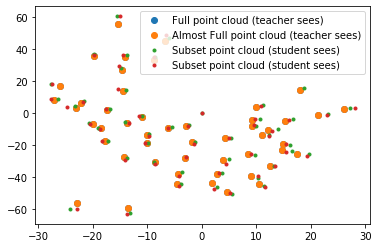

In [669]:
aug_example, _ = training_data.__getitem__(0)
raw_cloud, almost_cloud, subset_cloud, subset_cloud2 = aug_example[:4]
plt.plot(np.squeeze(raw_cloud[:, :, 1]), np.squeeze(raw_cloud[:, :, 2]), 'o', label="Full point cloud (teacher sees)")
plt.plot(np.squeeze(raw_cloud[:, :, 1]), np.squeeze(raw_cloud[:, :, 2]), 'o', label="Almost Full point cloud (teacher sees)")
plt.plot(np.squeeze(subset_cloud[:, :, 1]), np.squeeze(subset_cloud[:, :, 2]), '.', label="Subset point cloud (student sees)")
plt.plot(np.squeeze(subset_cloud2[:, :, 1]), np.squeeze(subset_cloud2[:, :, 2]), '.', label="Subset point cloud (student sees)")
plt.legend()

In [178]:
# ============ building student and teacher networks ... ============
model_opt = dict(in_channels=batch_sz, dim_h=n_neighbors, dim_w=3, heads=8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

student = RectAxialEncoder(**model_opt).to(device)
teacher = RectAxialEncoder(**model_opt).to(device)

# teacher and student start with the same weights
teacher.load_state_dict(student.state_dict())
# there is no backpropagation through the teacher, so no need for gradients
for p in teacher.parameters():
    p.requires_grad = False

print("Initialized")

Initialized


In [671]:
# ============ preparing loss ... ============
nepochs = 10

args = dict(epochs=nepochs, clip_grad=False, freeze_last_layer=False)

dino_loss = DINOLoss(
    dim_h,
    dim_w,
    local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
    nepochs=nepochs
).cuda()

In [672]:
lr = 0.001
wd = 1e-5
momentum = 0.9

optimizer = torch.optim.Adam(student.parameters(), lr = lr, weight_decay = wd)

In [ ]:
start_epoch = 0

student.train()

start_time = time.time()
print("Starting DINO training !")
with wandb.init(project="dino-project", entity="charlesfieseler"):
    wandb.watch(student, log='all', log_freq=1)
    for epoch in tqdm(range(start_epoch, args['epochs'])):
        # data_loader.sampler.set_epoch(epoch)

        # ============ training one epoch of DINO ... ============
        train_stats = train_one_epoch(student, teacher, None, dino_loss, training_data,
                        optimizer, lr, wd, momentum, epoch,
                        None, args)

        # ============ writing logs ... ============
        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'args': args,
            'dino_loss': dino_loss.state_dict(),
        }
        
        wandb.log({'Loss': train_stats.item()})
        # Logs a plot of the embedding and point clouds
        validation_epoch_end(teacher, data_worm0, data_worm1, worm0, worm1, all_anchors=[0])
    #     if fp16_scaler is not None:
    #         save_dict['fp16_scaler'] = fp16_scaler.state_dict()

    #     utils.save_on_master(save_dict, os.path.join(args.output_dir, 'checkpoint.pth'))
    #     if args.saveckp_freq and epoch % args.saveckp_freq == 0:
    #         utils.save_on_master(save_dict, os.path.join(args.output_dir, f'checkpoint{epoch:04}.pth'))
        # log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
        #              'epoch': epoch}

Starting DINO training !


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/846 [00:00<?, ?it/s]

Loss is 232.80551147460938


  0%|          | 0/846 [00:00<?, ?it/s]

Loss is 157.57301330566406


  0%|          | 0/846 [00:00<?, ?it/s]

Loss is 106.06136322021484


  0%|          | 0/846 [00:00<?, ?it/s]

Loss is 85.25587463378906


  0%|          | 0/846 [00:00<?, ?it/s]

# Apply to next volume using knn

In [648]:
data_worm0 = PointCloudDataset(augmentation, num_volumes=1, start_volume=0)
data_worm1 = PointCloudDataset(augmentation, num_volumes=1, start_volume=1)

# all_embeddings = [teacher(torch.unsqueeze(dat.float(), dim=0).to(device)).to('cpu') for dat in test_data]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [649]:
t = 0
worm0 = build_worm_at_time(t)

# Get next data
first_data = []
for i_anchor in range(len(worm0.neuron_zxy)):
    pts = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
    first_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))

all_first_embeddings = [teacher(torch.unsqueeze(dat.float(), dim=0).to(device)).to('cpu') for dat in first_data]

t = 1
worm1 = build_worm_at_time(t)

# Get next data
next_data = []
for i_anchor in range(len(worm0.neuron_zxy)):
    pts = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
    next_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))

all_next_embeddings = [teacher(torch.unsqueeze(dat.float(), dim=0).to(device)).to('cpu') for dat in next_data]

In [650]:
def flatten_embeddings(list_of_embedding):
    flat_list = [np.reshape(np.squeeze(emb), (-1, 1)).numpy() for emb in list_of_embedding]
    return np.hstack(flat_list).T
    

In [651]:
all_v1_embeddings = flatten_embeddings(all_next_embeddings)
all_v0_embeddings = flatten_embeddings(all_first_embeddings)
all_v0_embeddings.shape

(155, 150)

In [652]:
from sklearn.neighbors import NearestNeighbors

v0_neighbor_obj = NearestNeighbors(n_neighbors=10).fit(all_v0_embeddings)

matches_with_conf = []
for i, embedding1 in enumerate(all_v1_embeddings):
    closest_dist, closest_ind = v0_neighbor_obj.kneighbors(np.reshape(embedding1, (1, -1)), 1)
    matches_with_conf.append((i, closest_ind[0][0], closest_dist[0][0]))

Text(0.5, 1.0, 'Embeddings for the two point clouds (dist=40.60665512084961)')

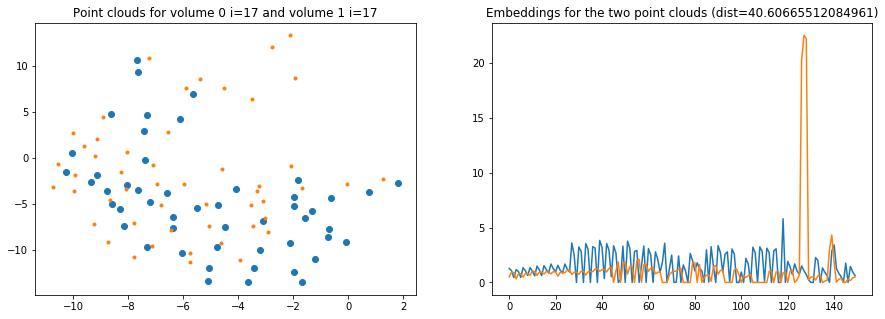

In [653]:
# Plot an original data point and its KNOWN match
i_anchor = 17
i_match = 17

n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
dino_matches = MatchesWithConfidence.matches_from_array(np.array(matches_with_conf))
n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_match, n_neighbors=n_neighbors)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n0[:, 1], n0[:, 2], 'o')
plt.plot(n1[:, 1], n1[:, 2], '.')
plt.title(f"Point clouds for volume 0 i={i_anchor} and volume 1 i={i_match}")

plt.subplot(1,2,2)
plt.plot(all_v0_embeddings[i_anchor,:])
plt.plot(all_v1_embeddings[i_match,:])
plt.title(f"Embeddings for the two point clouds (dist={np.linalg.norm(all_v0_embeddings[i_anchor,:]-all_v1_embeddings[i_match,:])})")

In [654]:
# n0

Text(0.5, 1.0, 'Embeddings for the two point clouds (dist=16.161396026611328)')

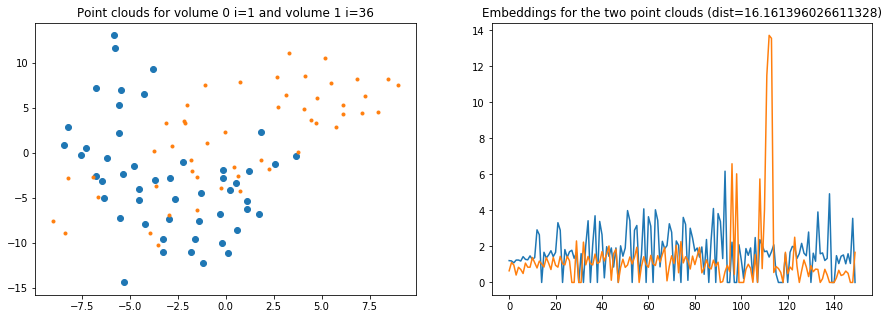

In [655]:
# Plot an original data point and its knn closest match
i_anchor = 1

n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
dino_matches = MatchesWithConfidence.matches_from_array(np.array(matches_with_conf))
i_match = dino_matches.get_mapping_0_to_1()[i_anchor]
n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_match, n_neighbors=n_neighbors)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n0[:, 1], n0[:, 2], 'o')
plt.plot(n1[:, 1], n1[:, 2], '.')
plt.title(f"Point clouds for volume 0 i={i_anchor} and volume 1 i={i_match}")

plt.subplot(1,2,2)
plt.plot(all_v0_embeddings[i_anchor,:])
plt.plot(all_v1_embeddings[i_match,:])
plt.title(f"Embeddings for the two point clouds (dist={matches_with_conf[i_anchor][-1]})")

In [656]:
# matches_with_conf

In [350]:
from DLC_for_WBFM.utils.pipeline.matches_class import MatchesWithConfidence 
from scipy.spatial import distance

dino_dist = distance.cdist(all_v1_embeddings, all_v0_embeddings)
dino_matches = MatchesWithConfidence.matches_from_distance_matrix(dino_dist)
# dino_matches.get_mapping_0_to_1()

In [480]:
# project_data.raw_matches[(0,1)].final_matches

In [321]:
# Plot PCA projections
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True).fit(all_v0_embeddings)
pca_proj_v0 = pca.transform(all_v0_embeddings)
pca_proj_v1 = pca.transform(all_v1_embeddings)


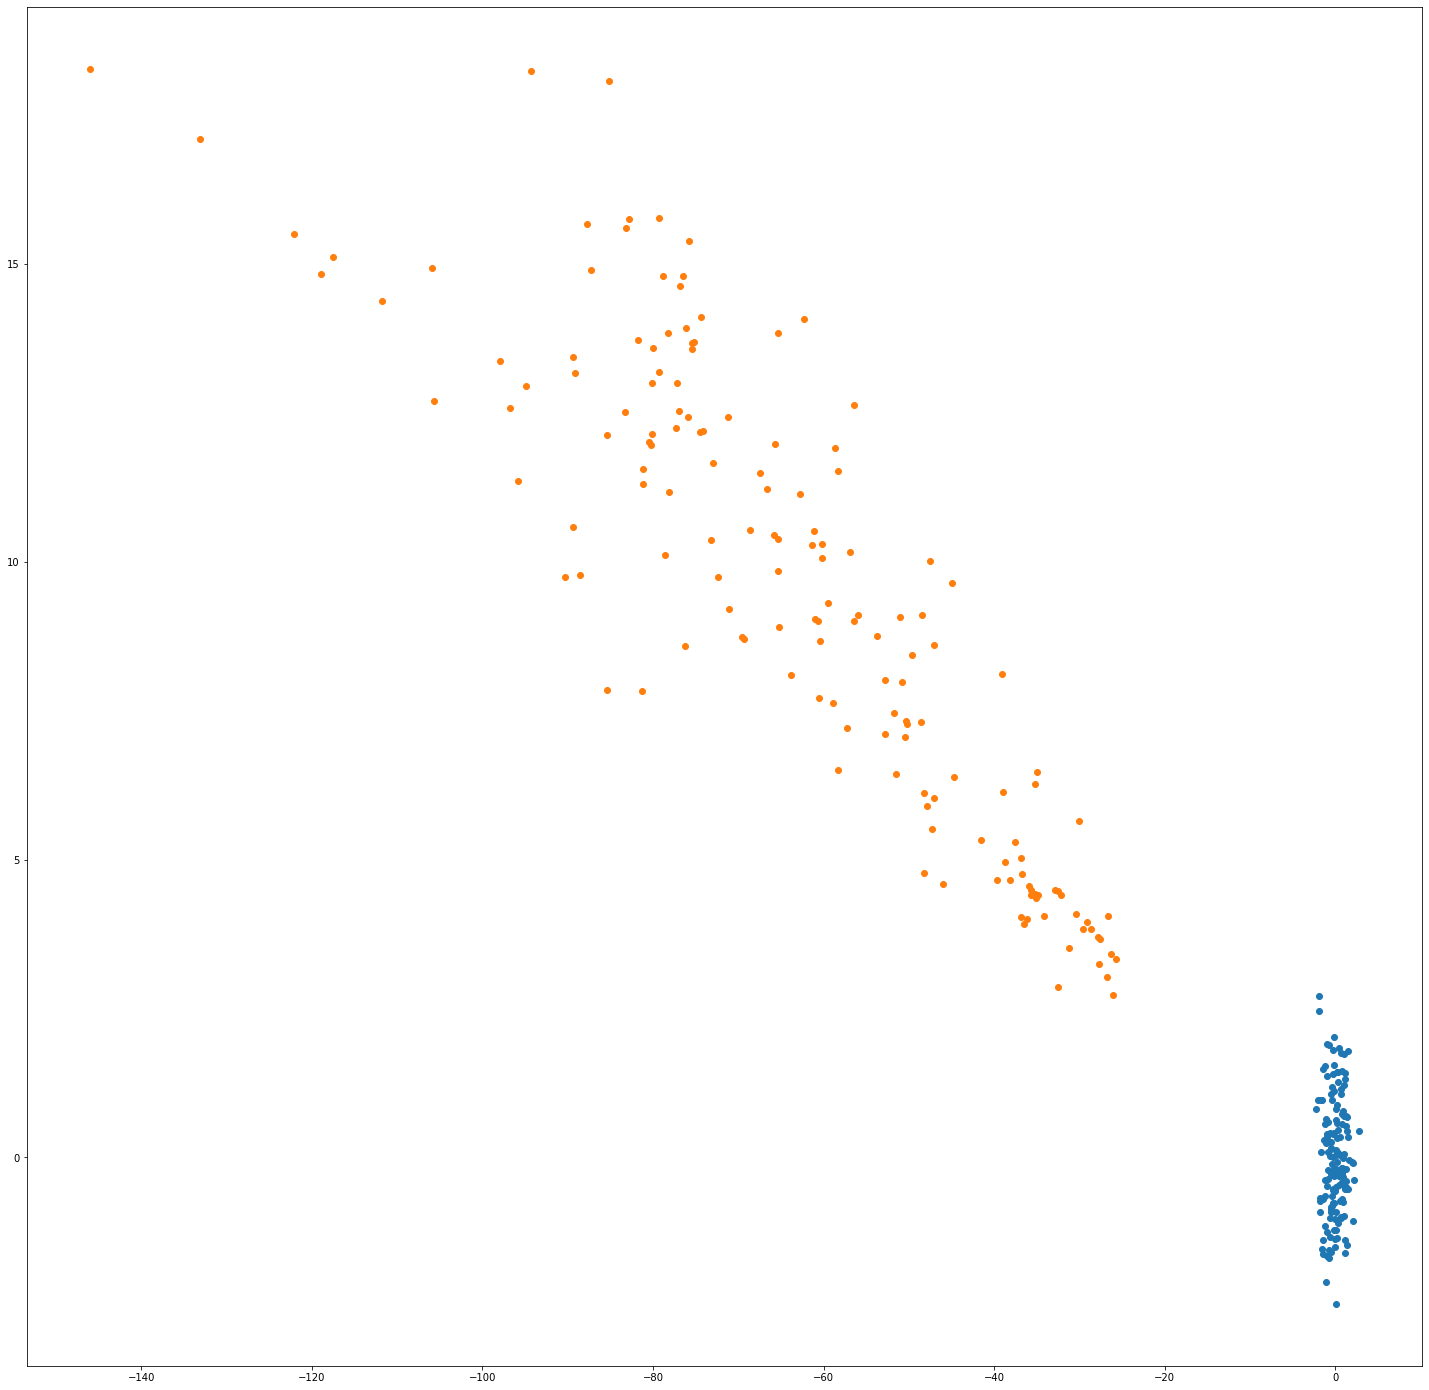

In [322]:
plt.figure(figsize=(25,25))
plt.plot(pca_proj_v0[:, 0], pca_proj_v0[:, 1], 'o')
plt.plot(pca_proj_v1[:, 0], pca_proj_v1[:, 1], 'o')

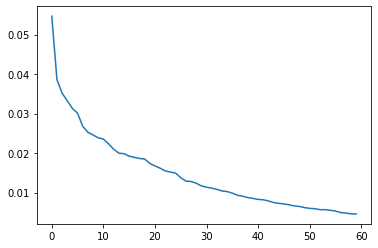

In [324]:
pca = PCA(n_components=60, whiten=True).fit(all_v0_embeddings)
plt.plot(pca.explained_variance_ratio_)

In [274]:
# project_data.napari_of_single_match((0,1))

# t-SNE instead of PCA

In [657]:
from sklearn.manifold import TSNE

tsne_embeddings = TSNE(n_components=2, init='random').fit_transform(all_v0_embeddings.T)
# tsne_proj_v0 = tsne.transform(all_v0_embeddings)
# tsne_proj_v1 = tsne.transform(all_v1_embeddings)

In [658]:
tsne_embeddings.shape

(150, 2)

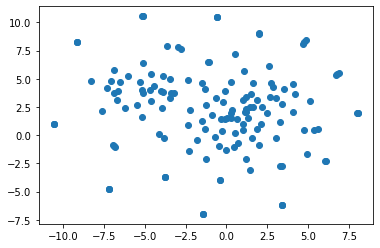

In [659]:
plt.plot(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 'o')

# Rewrite the axial attention block to deal with rectangular input

In [10]:
from einops import rearrange
from torch import nn

from self_attention_cv import AxialAttention

def _conv2d1x1(in_channels, out_channels, stride=1):
    """1x1 convolution for contraction and expansion of the channels dimension
    conv is followed by batch norm"""
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                         nn.BatchNorm2d(out_channels))


class RectAxialAttentionBlock(nn.Module):
    def __init__(self, in_channels, dim_h, dim_w, heads=8, dim_head=None):
        """
        Slight modification: different dims for x and y
        
        Axial-attention block implementation as described in:
        paper: https://arxiv.org/abs/2003.07853 , Fig. 2 page 7
        blogpost: TBA
        official code: https://github.com/csrhddlam/axial-deeplab
        Args:
            in_channels:
            dim: token's dim
            heads: the number of distict head representations
            axial_att: whether to use axial att or MHSA
            dim_head: for MHSA only
        """
        super().__init__()
        self.dim_h = dim_h
        self.dim_w = dim_w
        self.heads = heads
        d_in = 128  # hardcoded

        # brings the input channels to 128 feature maps
        self.in_conv1x1 = _conv2d1x1(in_channels, d_in)
        self.out_conv1x1 = _conv2d1x1(d_in, in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.dim_head = d_in // self.heads
        self.height_att = AxialAttention(dim=dim_h, in_channels=d_in, heads=heads)
        self.width_att = AxialAttention(dim=dim_w, in_channels=d_in, heads=heads)

    def forward(self, x_in):
        assert x_in.dim() == 4, f'Ensure your input is 4D: [batch,channels, height,width], not {x_in.dim()}'
        x = self.relu(self.in_conv1x1(x_in))
        # merge batch dim with width
        x = rearrange(x, 'b c h w -> (b w) c h')
        x = self.height_att(x)
        # decompose width + merge batch with height
        x = rearrange(x, '(b w) c h  -> (b h) c w', w=self.dim_w)
        x = self.relu(self.width_att(x))
        x = rearrange(x, '(b h) c w -> b c h w', h=self.dim_h)
        return self.relu(self.out_conv1x1(x) + x_in)

In [11]:
class RectAxialEncoder(nn.Module):
    """
    Uses just RectAxialAttentionBlock blocks instead of regular transformers
    """
    
    def __init__(self, in_channels, dim_h, dim_w, blocks=6, heads=8, dim_head=None):
        super().__init__()
        self.block_list = [RectAxialAttentionBlock(in_channels, dim_h, dim_w, heads, dim_head) for _ in range(blocks)]
        self.layers = nn.ModuleList(self.block_list)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [660]:
from torchvision import transforms
from torch import nn

class ReplaceRandomPoint(nn.Module):
    def __init__(self, num_to_replace=1, scale=1, DEBUG=False):
        self.num_to_replace = num_to_replace
        self.scale = scale
        self.DEBUG = DEBUG
    
    def forward(self, pts):
        i_to_replace = torch.randperm(pts.shape[0])[:self.num_to_replace]
        pt_sz = pts[0].shape
        if self.DEBUG:
            print(i_to_replace)
            print("Original points: ", pts)
        
        for i in i_to_replace:
            new_pt = self.scale * torch.rand(pt_sz)
            pts[i, :] = new_pt
            if self.DEBUG:
                print(new_pt)
            
        return pts

    
class ZeroRandomPoint(nn.Module):
    # TODO: better way to mask them?
    def __init__(self, num_to_replace=1):
        super(ZeroRandomPoint, self).__init__()
        self.num_to_replace = num_to_replace
    
    def forward(self, pts):
        assert pts.dim() == 3
        i_to_zero = torch.randperm(pts.shape[1])[:self.num_to_replace]
        for i in i_to_zero:
            pts[:, i, :] = 0.0
        return pts


class JitterAllPoints(nn.Module):
    # Random scaling, different for each point
    def __init__(self, percent_jitter=0.1):
        super(JitterAllPoints, self).__init__()
        self.percent_jitter = percent_jitter
    
    def forward(self, pts):
        jitter = 1.0 + self.percent_jitter * torch.rand(pts.shape)
        return pts * jitter

    
class TranslateAllPoints(nn.Module):
    # Random scaling, different for each point
    def __init__(self, percent_translation=0.1):
        super(TranslateAllPoints, self).__init__()
        self.percent_translation = percent_translation
    
    def forward(self, pts):
        translation = self.percent_translation * torch.rand(1) *  torch.mean(pts)
        return pts + translation
    
        
class PointCloudAugmentationDINO(object):
    """
    Following augmentations:
        Replace neuron with outlier
        Add jitter to location
        Scale
    TODO:
        RandomAffine
        (see: https://pytorch3d.readthedocs.io/en/latest/modules/transforms.html)
    """
    def __init__(self, 
                 teacher_num_to_replace=0, student_num_to_replace=1, 
                 teacher_percent_jitter=0.01, student_percent_jitter=0.1,
                 teacher_percent_translation=0.01, student_percent_translation=0.1,
                 student_crops_number=2):
        normalize = nn.Sequential(
            transforms.Normalize(0.0, 0.229),
        )
        # normalize = transforms.Compose([
        #     transforms.ToTensor(),
        #     # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        # ])
        
        replace_teacher_random = torch.jit.script(ZeroRandomPoint(num_to_replace=teacher_num_to_replace))
        replace_student_random = torch.jit.script(ZeroRandomPoint(num_to_replace=student_num_to_replace))
        jitter_teacher_random = torch.jit.script(JitterAllPoints(percent_jitter=teacher_percent_jitter))
        jitter_student_random = torch.jit.script(JitterAllPoints(percent_jitter=student_percent_jitter))
        translate_teacher_random = torch.jit.script(TranslateAllPoints(percent_translation=teacher_percent_translation))
        translate_student_random = torch.jit.script(TranslateAllPoints(percent_translation=student_percent_translation))

        # first global crop - NO replacement, only jitter and translation
        self.global_transfo1 = nn.Sequential(
            jitter_teacher_random,
            normalize,
            # torch.squeeze # Output has a middle dimension of 1 for some reason
        )
        # second global crop
        self.global_transfo2 = nn.Sequential(
            jitter_teacher_random,
            translate_teacher_random,
            replace_teacher_random,
            normalize,
            # torch.squeeze
        )
        # transformation for the local small crops
        self.student_crops_number = student_crops_number
        self.local_transfo = nn.Sequential(
            jitter_student_random,
            translate_student_random,
            replace_student_random,
            normalize,
            # torch.squeeze
        )

    def __call__(self, pts):
        crops = []
        crops.append(self.global_transfo1(pts))
        crops.append(self.global_transfo2(pts))
        for _ in range(self.student_crops_number):
            crops.append(self.local_transfo(pts))
        # Return full shape
        crops = torch.cat([torch.unsqueeze(c, dim=0).float() for c in crops], dim=0)
        # for c in crops:
        #     c = torch.unsqueeze(c, dim=0)
        return crops

In [418]:
# import torch.distributed as dist

class DINOLoss(nn.Module):
    def __init__(self, dim_h, dim_w, ncrops, warmup_teacher_temp=0.04, teacher_temp=0.04,
                 warmup_teacher_temp_epochs=0, nepochs=10, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        # Will be same size as the output of a block; in this case, 2d
        self.register_buffer("center", torch.zeros(1, dim_h, dim_w))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / len(teacher_output)
        # dist.all_reduce(batch_center)
        # batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [419]:
def train_one_epoch(student, teacher, _teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr, wd, momentum, epoch,
                    fp16_scaler, args):
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # header = 'Epoch: [{}/{}]'.format(epoch, args.epochs)
    for it, (images, _) in enumerate(tqdm(data_loader, leave=False)):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            # param_group["lr"] = lr_schedule[it]
            param_group["lr"] = lr
            if i == 0:  # only the first group is regularized
                # param_group["weight_decay"] = wd_schedule[it]
                param_group["weight_decay"] = wd

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        images = torch.unsqueeze(torch.cat(images), dim=1)
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()))
            sys.exit(1)
        # else:
        #     print("Loss is {}".format(loss.item()))
            
        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args['clip_grad']:
                param_norms = utils.clip_gradients(student, args['clip_grad'])
            # utils.cancel_gradients_last_layer(epoch, student,
            #                                   args['freeze_last_layer'])
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args['clip_grad']:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args['clip_grad'])
            utils.cancel_gradients_last_layer(epoch, student,
                                              args['freeze_last_layer'])
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            # m = momentum_schedule[it]  # momentum parameter
            m = momentum
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        torch.cuda.synchronize()
        # metric_logger.update(loss=loss.item())
        # metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        # metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    print("Loss is {}".format(loss.item()))
    return loss
    # gather the stats from all processes
    # metric_logger.synchronize_between_processes()
    # print("Averaged stats:", metric_logger)
    # return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [638]:
# Following: https://sachinruk.github.io/blog/pytorch/pytorch%20lightning/loss%20function/2021/08/01/dino-self-supervised-vision-transformers.html

def validation_epoch_end(teacher, data_worm0, data_worm1, worm0, worm1, all_anchors=None):
    if all_anchors is None:
        all_anchors = [0]
    # Match two point clouds (embeddings)
    embed_worm0 = [teacher(dat[0].to(device))[0].cpu() for dat in data_worm0]
    embed_worm1 = [teacher(dat[0].to(device))[0].cpu() for dat in data_worm1]
    
    all_v0_embeddings = flatten_embeddings(embed_worm0)
    all_v1_embeddings = flatten_embeddings(embed_worm1)
    v0_neighbor_obj = NearestNeighbors(n_neighbors=10).fit(all_v0_embeddings)

    matches_with_conf = []
    for i, embedding1 in enumerate(all_v1_embeddings):
        closest_dist, closest_ind = v0_neighbor_obj.kneighbors(np.reshape(embedding1, (1, -1)), 1)
        matches_with_conf.append((i, closest_ind[0][0], closest_dist[0][0]))
    dino_matches = MatchesWithConfidence.matches_from_array(np.array(matches_with_conf))
    
    # Plot an original data point and its knn closest match
    matches = dino_matches.get_mapping_0_to_1()
    all_anchors = [list(matches.keys())[i] for i in all_anchors]
    plt_rows = []
    for i_anchor in all_anchors:
        i_match = matches[i_anchor]

        n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
        n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_match, n_neighbors=n_neighbors)

        fig = plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(n0[:, 1], n0[:, 2], 'o')
        plt.plot(n1[:, 1], n1[:, 2], '.')
        plt.title(f"Point clouds for volume 0 i={i_anchor} and volume 1 i={i_match}")

        plt.subplot(1,2,2)
        plt.plot(all_v0_embeddings[i_anchor,:])
        plt.plot(all_v1_embeddings[i_match,:])
        plt.title(f"Embeddings for the two point clouds (dist={matches_with_conf[i_anchor][-1]})")

        # valid_embeds = torch.cat([pred for pred in validation_step_outputs])
        # columns = ["image"] + [f"closest_{i+1}" for i in range(TOPK)]
        # indices = np.random.choice(len(self.valid_files), VALID_IMAGES, replace=False)
        # rows = [get_closest_wandb_images(valid_embeds, i, self.valid_files) for i in indices]
        # table = wandb.Table(data=rows, columns=columns)
        # self.logger.experiment.log({f"epoch {self.current_epoch} results": table})
    wandb.log({"plot": plt})

Error: You must call wandb.init() before wandb.log()

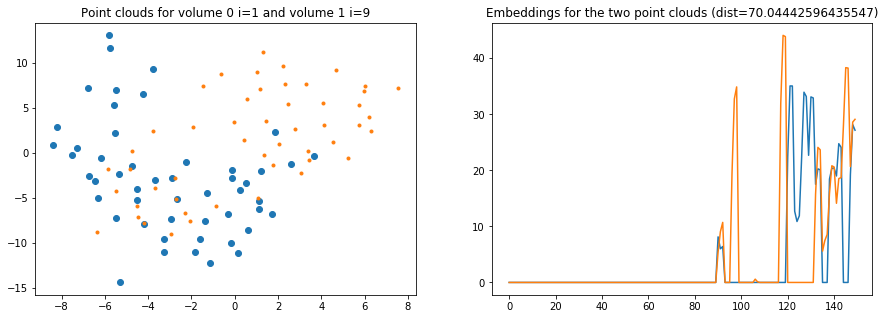

In [639]:
validation_epoch_end(teacher, data_worm0, data_worm1, worm0, worm1, all_anchors=[1])

Error: You must call wandb.init() before wandb.log()

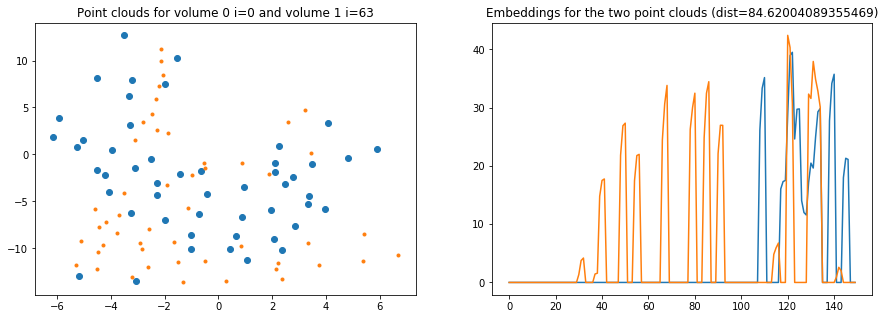

In [640]:
validation_epoch_end(teacher, data_worm0, data_worm1, worm0, worm1, all_anchors=[0])

In [612]:
worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)

array([[  5.01991575,   1.60322726,   0.36477554],
       [  5.82749967,  -0.21630438,  -1.481347  ],
       [  5.88803894,  -1.87100575,  -1.35918125],
       [  4.49595016,  -1.30360535,   2.37086924],
       [  5.6787326 ,  -2.65860821,   0.78963273],
       [  4.13064469,   1.20839168,   2.7302882 ],
       [  5.89578831,   3.244813  ,   0.78577383],
       [  6.77841921,  -0.16435277,  -3.71850124],
       [  7.25038637,  -3.48937639,  -1.46125347],
       [  5.30529934,  -3.78375477,   2.80709291],
       [  7.63369141,  -4.77345897,   0.1981207 ],
       [  7.70325881,   4.55304533,   1.37177168],
       [  9.68559344,   0.27882111,  -2.88438097],
       [  8.16699157,   3.29917863,   3.61376791],
       [  9.15321582,  -1.77299377,  -3.79590899],
       [  6.52378649,  -4.72522249,   4.26772281],
       [  8.25944514,  -4.47109978,  -3.42481172],
       [  8.85415399,  -3.12487626,  -4.24953083],
       [  8.74042155,  -4.97385136,   2.09272937],
       [ 10.30437422,  -5.36167

In [52]:
aug = PointCloudAugmentationDINO(10, 1, 2)

out = aug(torch.from_numpy(np.expand_dims(n0, axis=0)))

In [510]:
t0 = torch.from_numpy(np.expand_dims(n1, axis=0))

In [400]:
JitterAllPoints()(t0)

tensor([[[7.5543e-01, 9.2995e-01, 4.8971e-01],
         [4.0307e-01, 2.1578e-01, 6.6510e-01],
         [5.9375e-01, 9.7074e-01, 4.6909e-01],
         [3.8699e-01, 4.5842e-04, 2.3811e-01],
         [8.8494e+01, 7.4598e+01, 9.1312e+01],
         [6.1471e+01, 1.0479e+01, 7.2679e+01],
         [9.4777e-01, 4.0547e-01, 8.3134e-01],
         [8.7459e-01, 2.8747e-02, 1.3346e-01],
         [7.3945e-01, 4.3457e-01, 7.8139e-01],
         [4.8529e-01, 3.8706e-01, 6.8552e-01],
         [9.5523e-01, 8.9339e-01, 3.2307e-01],
         [8.0083e-01, 5.1905e-01, 3.0640e-01],
         [9.2789e-01, 1.6828e-01, 9.4848e-01],
         [4.1565e-01, 6.8020e-01, 5.1854e-01],
         [3.5754e-02, 5.2267e-01, 1.0090e+00],
         [1.7401e-01, 2.6382e-01, 3.5368e-01],
         [3.8526e-01, 8.8486e-01, 4.3955e-01],
         [4.3051e-01, 9.6122e-01, 8.9792e-02],
         [7.2439e-01, 9.2324e-01, 3.6262e-02],
         [4.0992e-01, 1.3920e-01, 7.4881e-01]]], dtype=torch.float64)

In [404]:
TranslateAllPoints()(t0)

tensor([[[ 1.1568,  1.3382,  0.8758],
         [ 0.8037,  0.6210,  1.0454],
         [ 0.9569,  1.3838,  0.8759],
         [ 0.7829,  0.4166,  0.6482],
         [83.2906, 71.1361, 87.9011],
         [58.1616, 10.2415, 71.7039],
         [ 1.3470,  0.8136,  1.2009],
         [ 1.2261,  0.4438,  0.5415],
         [ 1.1395,  0.8495,  1.1526],
         [ 0.8792,  0.7744,  1.0462],
         [ 1.3696,  1.3028,  0.7310],
         [ 1.2001,  0.9287,  0.7208],
         [ 1.2927,  0.5720,  1.3316],
         [ 0.8195,  1.0705,  0.9189],
         [ 0.4506,  0.9256,  1.3812],
         [ 0.5753,  0.6673,  0.7395],
         [ 0.7792,  1.2404,  0.8271],
         [ 0.8392,  1.2988,  0.5002],
         [ 1.0903,  1.3016,  0.4520],
         [ 0.8087,  0.5490,  1.1257]]], dtype=torch.float64)

In [506]:
replace_teacher_random = torch.jit.script(ZeroRandomPoint(num_to_replace=1))
# replace_teacher_random(t0)

In [513]:
for i in [1, 2]:
    print(t0[:, i, :])
    

tensor([[4.1306, 2.5120, 0.3594]], dtype=torch.float64)
tensor([[ 5.3053, -2.4801,  0.4362]], dtype=torch.float64)


In [398]:
torch.rand(1)

tensor([0.1119])

In [516]:
test_data[0][0].shape

torch.Size([4, 1, 50, 3])

In [518]:
test_data.preloaded_data[0].shape

torch.Size([1, 50, 3])

In [520]:
test_data.preloaded_data[0].dim()


3